In [1]:
import json
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from fwi_predict.utils.sklearn import DiurnalDetrend
from fwi_predict.wq import get_in_required_range

In [2]:
predict_df = pd.read_csv("../data/predict_dfs/train/jan_mar_25_w_metadata_predict_df.csv",
                         parse_dates=['sample_dt'],
                         index_col=0)

sentinel_features = pd.read_csv("../data/gcs/train/sentinel2/jan_mar_25_w_metadata.csv").drop(columns=['system:index', '.geo'])
predict_df = predict_df.merge(sentinel_features, on='sample_idx')

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])

#### First get some clarity on the data

In [3]:
time_of_day = predict_df['morning'].apply(lambda x: 'morning' if x else 'evening')
do_in_range = get_in_required_range(
    'do_mg_per_L',
    predict_df['do_mg_per_L'], 
    time_of_day
)
do_in_range = pd.Series(do_in_range, index=predict_df.index)
do_in_range.value_counts() * 100 / len(predict_df)

within    91.757387
below      6.687403
above      1.555210
Name: count, dtype: float64

In [4]:
target = 'do_mg_per_L'

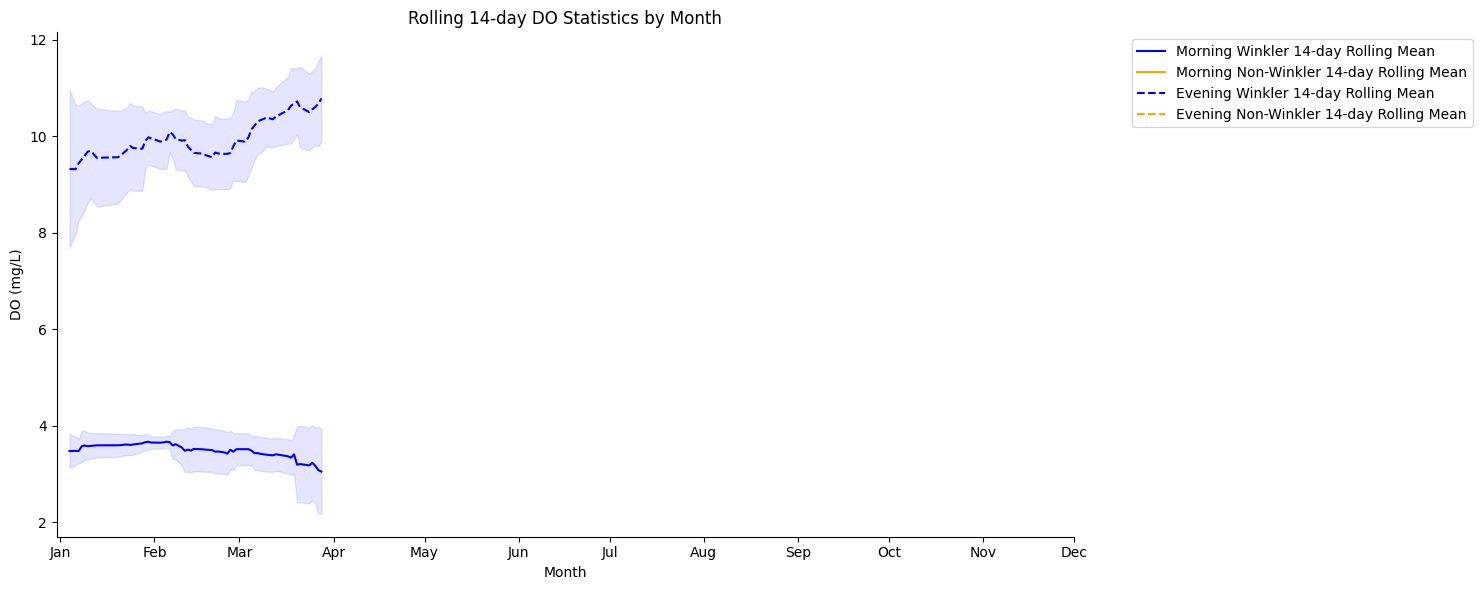


Summary Statistics for All DO Measurements:


,time_of_day,measurement_type,mean,std,count
0,Morning,Winkler,3.414506,0.817498,324.0
1,Morning,Non-Winkler,4.000000,NaN,1.0
2,Evening,Winkler,10.155031,1.363849,318.0
3,Evening,Non-Winkler,NaN,NaN,0.0


In [5]:
# Function to calculate rolling averages for DO measurements
def calculate_rolling_averages(df, window_size=7):
    """
    Calculate rolling window averages for dissolved oxygen measurements,
    separated by morning/evening and measurement type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing DO measurements with 'morning' and 'winkler' columns
    window_size : int, default=7
        Size of the rolling window in days
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with rolling averages for each group
    """
    # Create a copy to avoid SettingWithCopyWarning
    result_df = df.copy()
    
    # Add day of year column
    result_df['day_of_year'] = result_df['sample_dt'].dt.dayofyear
    
    # Ensure data is sorted by day of year
    result_df = result_df.sort_values('day_of_year')
    
    # Calculate rolling statistics for each combination of morning/evening and winkler/non-winkler
    groups = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['do_winkler'] == is_winkler)]
            
            daily_means = data.groupby(['day_of_year'])['do_mg_per_L'].mean()
            rolling_mean = daily_means.rolling(window=window_size, min_periods=3).mean()
            rolling_std = daily_means.rolling(window=window_size, min_periods=3).std()
            
            groups.append({
                'data': rolling_mean,
                'std': rolling_std,
                'label': f'{"Morning" if is_morning else "Evening"} {"Winkler" if is_winkler else "Non-Winkler"}',
                'color': 'blue' if is_winkler else 'orange',  # Same color for same measurement type
                'linestyle': '-' if is_morning else '--'
            })

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for group in groups:
        group['data'].plot(ax=ax, 
                         label=f"{group['label']} {window_size}-day Rolling Mean", 
                         color=group['color'],
                         linestyle=group['linestyle'])
        ax.fill_between(group['data'].index, 
                       group['data'] - group['std'],
                       group['data'] + group['std'],
                       alpha=0.1, 
                       color=group['color'])
    
    # Set x-axis ticks to show months
    month_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate middle of each month
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels)
    
    ax.set_title(f'Rolling {window_size}-day DO Statistics by Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('DO (mg/L)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary_stats = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['do_winkler'] == is_winkler)]
            stats = data['do_mg_per_L'].agg(['mean', 'std', 'count']).to_dict()
            stats['time_of_day'] = 'Morning' if is_morning else 'Evening'
            stats['measurement_type'] = 'Winkler' if is_winkler else 'Non-Winkler'
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df = summary_df[['time_of_day', 'measurement_type', 'mean', 'std', 'count']]
    
    print("\nSummary Statistics for All DO Measurements:")
    display(summary_df)

# Calculate rolling averages with 7-day window
rolling_window = 14
calculate_rolling_averages(predict_df, window_size=rolling_window)


In [6]:
# Create interactive plot of DO over time by pond
# Get all ponds ordered by number of observations
pond_order = predict_df.groupby('pond_id').size().sort_values(ascending=False).index.tolist()
predict_df['date'] = predict_df['sample_dt'].dt.date

# Get top 10 ponds for initial visibility
top_10_ponds = pond_order[:10]

fig = px.line(predict_df, 
                 x='date', 
                 y='do_mg_per_L',
                 color='pond_id',
                 facet_row='morning',
                 title='Dissolved Oxygen Over Time by Pond',
                 labels={'do_mg_per_L': 'Dissolved Oxygen (mg/L)',
                        'date': 'Date',
                        'pond_id': 'Pond ID',
                        'morning': 'Morning'},
                 category_orders={'pond_id': pond_order},
                 height=800)

# Add shaded regions for required DO ranges based on time of day
# Morning range (3-5 mg/L)
fig.add_hrect(y0=3, y1=5,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=2)  # Morning facet

# Evening range (8-12 mg/L) 
fig.add_hrect(y0=8, y1=12,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=1)  # Evening facet

# Update layout
fig.update_layout(
    showlegend=True,
    legend_title_text='Pond ID',
    title_x=0.5,
    height=800  # Increased height for better visibility
)

# Show only top 10 ponds initially but allow selection of others
fig.for_each_trace(lambda t: t.update(visible='legendonly') 
                   if t.name not in top_10_ponds 
                   else t.update(visible=True))

fig.show()


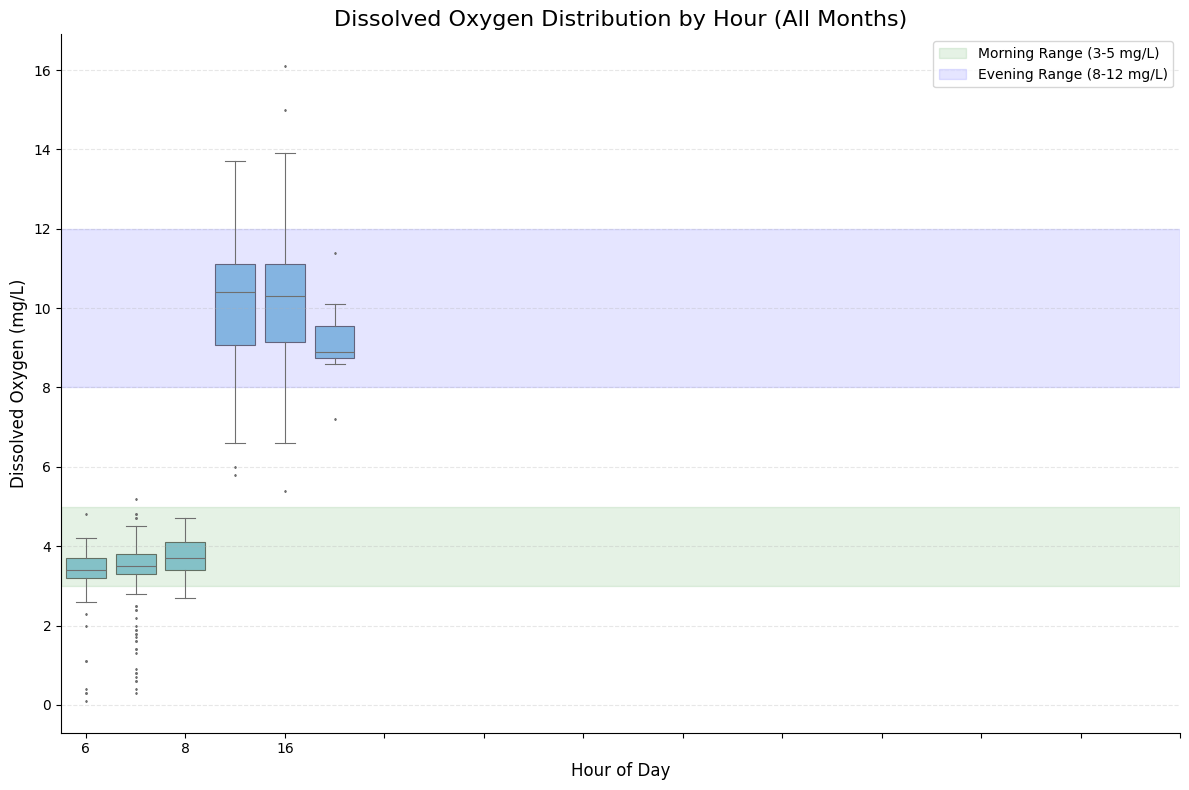

In [7]:
# Create a figure for boxplots of dissolved oxygen by hour (not disaggregated by month)
plt.figure(figsize=(12, 8))

# Create boxplot of DO by hour
ax = sns.boxplot(x='hour', y='do_mg_per_L', data=predict_df, 
                color='skyblue', fliersize=1, linewidth=0.8,
                order=sorted(predict_df['hour'].unique()))  # Sort hours numerically

# Customize the appearance
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
plt.title('Dissolved Oxygen Distribution by Hour (All Months)', fontsize=16)
plt.xticks(range(0, 24, 2))  # Set x-ticks every 2 hours

# Remove spines to make it prettier
sns.despine(left=False, bottom=False)

# Add light grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add shaded regions for required DO ranges
plt.axhspan(3, 5, alpha=0.1, color='green', label='Morning Range (3-5 mg/L)')
plt.axhspan(8, 12, alpha=0.1, color='blue', label='Evening Range (8-12 mg/L)')

# Add legend
plt.legend(loc='best', frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()

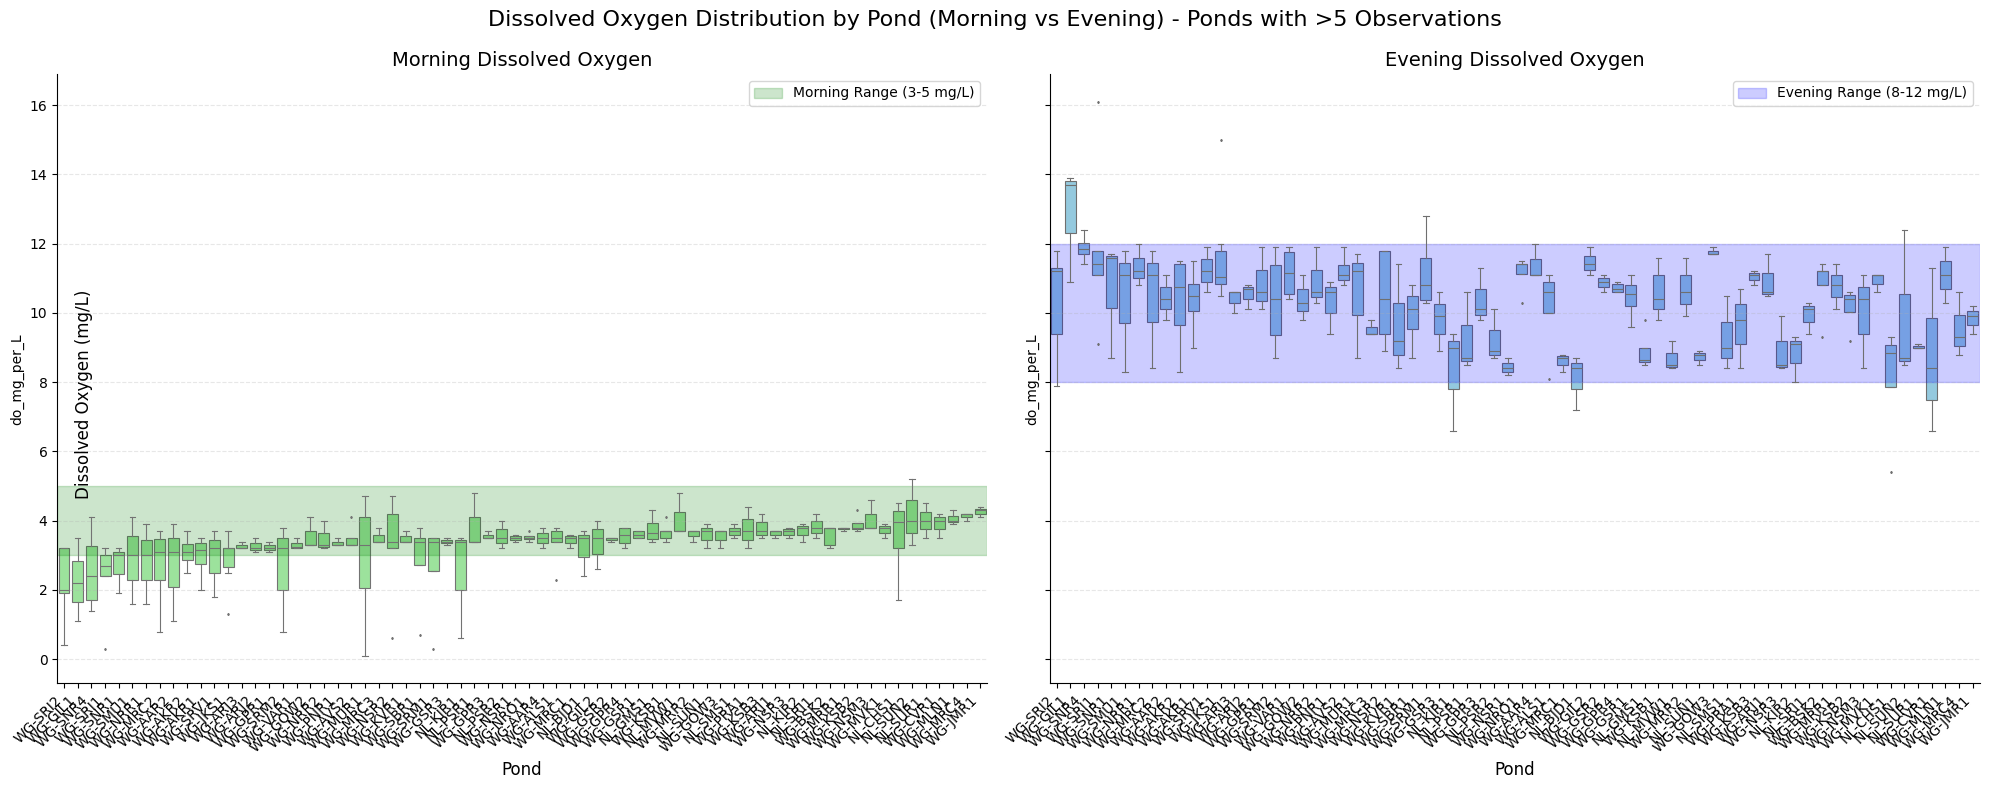

In [8]:
# Create a new column to categorize time as morning or evening
predict_df['time_of_day'] = 'Evening'
predict_df.loc[predict_df['hour'] < 12, 'time_of_day'] = 'Morning'

# Count observations per pond
pond_counts = predict_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 5].index.tolist()

# Filter to only include ponds with more than 10 observations
filtered_df = predict_df[predict_df['pond_id'].isin(valid_ponds)]

# Calculate medians for sorting by morning values
morning_medians = filtered_df[filtered_df['time_of_day'] == 'Morning'].groupby('pond_id')['do_mg_per_L'].median()
pond_order = morning_medians.sort_values().index.tolist()

# Create a figure for faceted boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colors for each time of day
colors = {'Morning': 'lightgreen', 'Evening': 'skyblue'}

# Create separate boxplots for morning and evening
for i, time_period in enumerate(['Morning', 'Evening']):
    # Filter data for this time period
    period_data = filtered_df[filtered_df['time_of_day'] == time_period]
    
    # Create boxplot
    sns.boxplot(x='pond_id', y='do_mg_per_L', 
                data=period_data, 
                color=colors[time_period],
                fliersize=1, linewidth=0.8,
                order=pond_order,
                ax=axes[i])
    
    # Customize appearance
    axes[i].set_xlabel('Pond', fontsize=12)
    axes[i].set_title(f'{time_period} Dissolved Oxygen', fontsize=14)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Remove spines
    sns.despine(ax=axes[i], left=False, bottom=False)
    
    # Add grid
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add appropriate shaded region for required DO range
    if time_period == 'Morning':
        axes[i].axhspan(3, 5, alpha=0.2, color='green', label='Morning Range (3-5 mg/L)')
    else:
        axes[i].axhspan(8, 12, alpha=0.2, color='blue', label='Evening Range (8-12 mg/L)')
    
    # Add legend
    axes[i].legend(loc='best', frameon=True)

# Set common y-label
fig.text(0.04, 0.5, 'Dissolved Oxygen (mg/L)', va='center', rotation='vertical', fontsize=12)

# Add overall title
plt.suptitle('Dissolved Oxygen Distribution by Pond (Morning vs Evening) - Ponds with >5 Observations', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


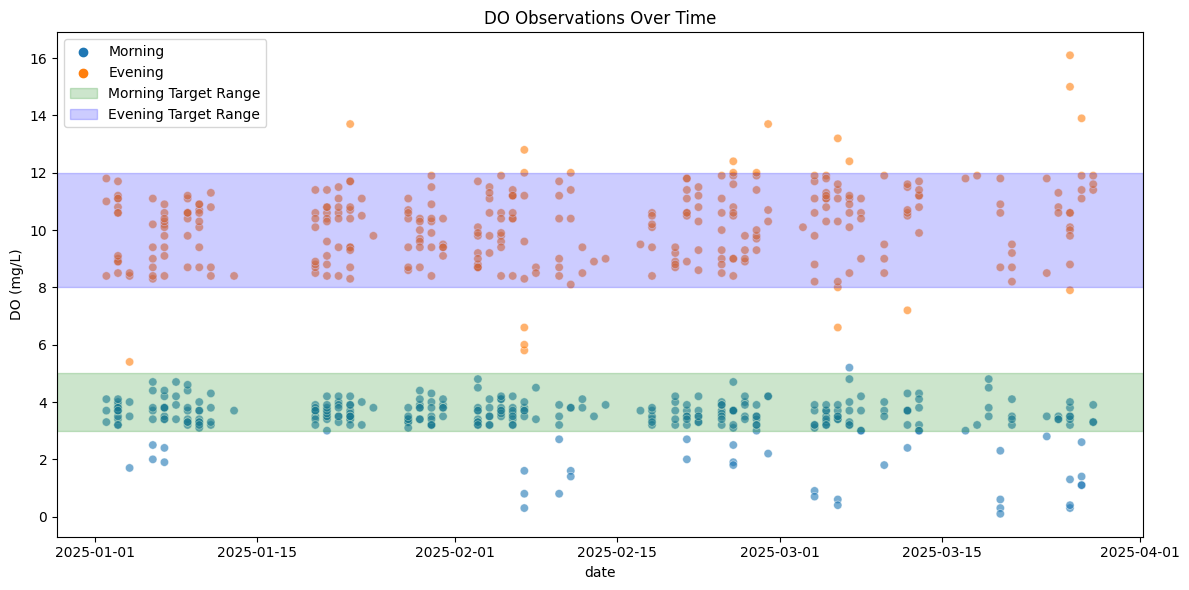

In [9]:
def plot_do_observations_with_bands(df):
    """
    Plot DO observations over time with bands indicating in/out of range,
    colored by morning/evening. Creates a 1x2 subplot comparing Winkler and Taiwan data.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    # Create figure with two subplots
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create morning/evening labels
    df['time_of_day'] = df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
    
    # Plot scatter points
    sns.scatterplot(data=df,
                    x='date',
                    y='do_mg_per_L',
                    hue='time_of_day',
                    alpha=0.6,
                    ax=ax)
    
    # Add bands for acceptable DO ranges
    # Morning range: ~3-5 mg/L
    ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
    # Evening range: ~8-12 mg/L  
    ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
    
    ax.set_title(f'DO Observations Over Time')
    ax.set_ylabel('DO (mg/L)')
    ax.legend(title='')
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands(predict_df)


C:\Users\squaade\AppData\Local\Temp\ipykernel_7624\2097639445.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_7624\2097639445.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



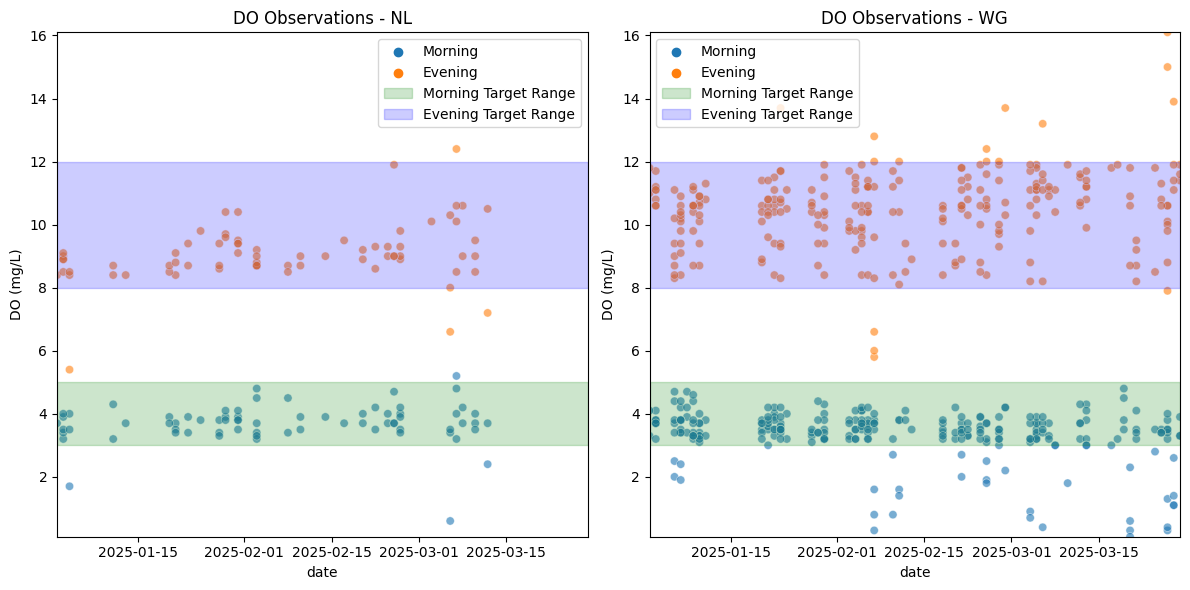

In [10]:
def plot_do_observations_with_bands_by_region(df):
    """
    Plot DO observations by day of year with bands indicating in/out of range,
    colored by morning/evening. Creates a 2x2 subplot comparing Winkler and Taiwan data
    across different regions.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    regions = df['region'].unique().tolist()
    fig, axes = plt.subplots(1, len(regions), figsize=(12, 6))
    axes = axes.flatten()
    
    # Find global min and max for x and y axes
    min_date = df['date'].min()
    max_date = df['date'].max()
    min_do = df['do_mg_per_L'].min()
    max_do = df['do_mg_per_L'].max()
    
    plot_idx = 0
    for region in regions:
        ax = axes[plot_idx]
        region_df = df[df['region'] == region]
        
        region_df['time_of_day'] = region_df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
        
        sns.scatterplot(data=region_df,
                        x='date',
                        y='do_mg_per_L',
                        hue='time_of_day',
                        alpha=0.6,
                        ax=ax)
        
        ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
        ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
        
        ax.set_title(f'DO Observations - {region}')
        ax.set_ylabel('DO (mg/L)')
        ax.legend(title='')
        
        # Set standardized x and y axes
        ax.set_xlim(min_date, max_date)
        ax.set_ylim(min_do, max_do)
        
        plot_idx += 1

    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands_by_region(predict_df)

In [11]:
outdir = Path("../models/do_mg_per_L")
model_names = set([file.stem.removesuffix('_features') for file in outdir.iterdir()])
model_names.remove('all')

model_dict = {}
for name in model_names:
	model_dict[name] = {}

	with open(outdir / f'{name}.pkl', 'rb') as f:
		model_dict[name]['model'] = pickle.load(f)

	with open(outdir / f'{name}_features.json', 'r') as f:
		model_dict[name]['feature_names'] = json.load(f)

In [12]:
preds_dict = {
    name: item['model'].predict(predict_df) for name, item in model_dict.items()
}

In [13]:
from sklearn.metrics import root_mean_squared_error, precision_score, recall_score, r2_score

from fwi_predict.constants import WQ_RANGES


Analyzing all_features model...

Below range DO (n=43)
RMSE: 2.834 | R²: -0.970
Precision: 0.000 | Recall: 0.000

Within range DO (n=590)
RMSE: 0.901 | R²: 0.928
Precision: 0.917 | Recall: 0.973

Above range DO (n=10)
RMSE: 3.208 | R²: -0.340
Precision: 0.059 | Recall: 0.100


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



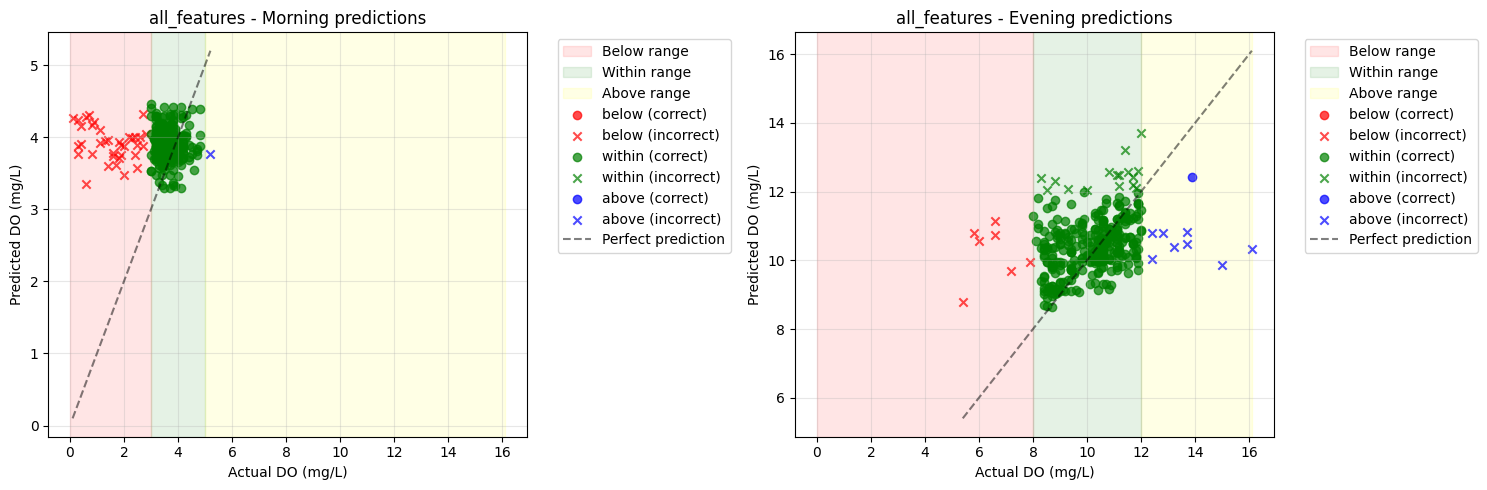


Analyzing base model...

Below range DO (n=43)
RMSE: 2.880 | R²: -1.034
Precision: 0.000 | Recall: 0.000

Within range DO (n=590)
RMSE: 1.141 | R²: 0.884
Precision: 0.915 | Recall: 0.927

Above range DO (n=10)
RMSE: 3.271 | R²: -0.394
Precision: 0.022 | Recall: 0.100


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



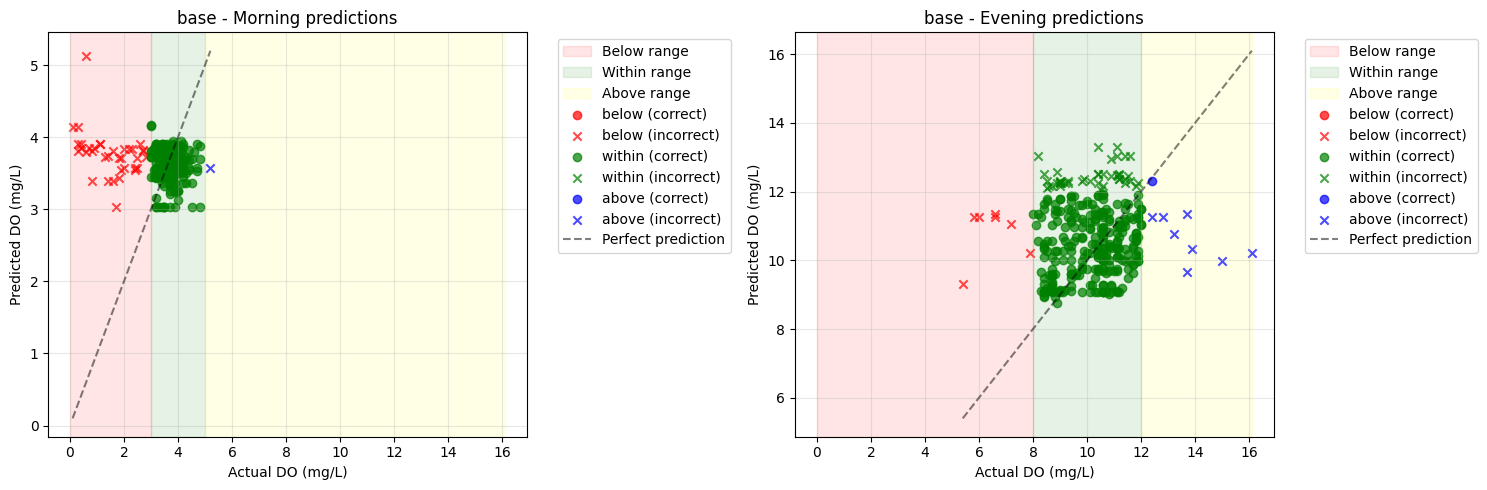


Analyzing all_without_lag model...

Below range DO (n=43)
RMSE: 3.314 | R²: -1.694
Precision: 0.000 | Recall: 0.000

Within range DO (n=590)
RMSE: 1.999 | R²: 0.643
Precision: 0.914 | Recall: 0.864

Above range DO (n=10)
RMSE: 3.793 | R²: -0.874
Precision: 0.038 | Recall: 0.300


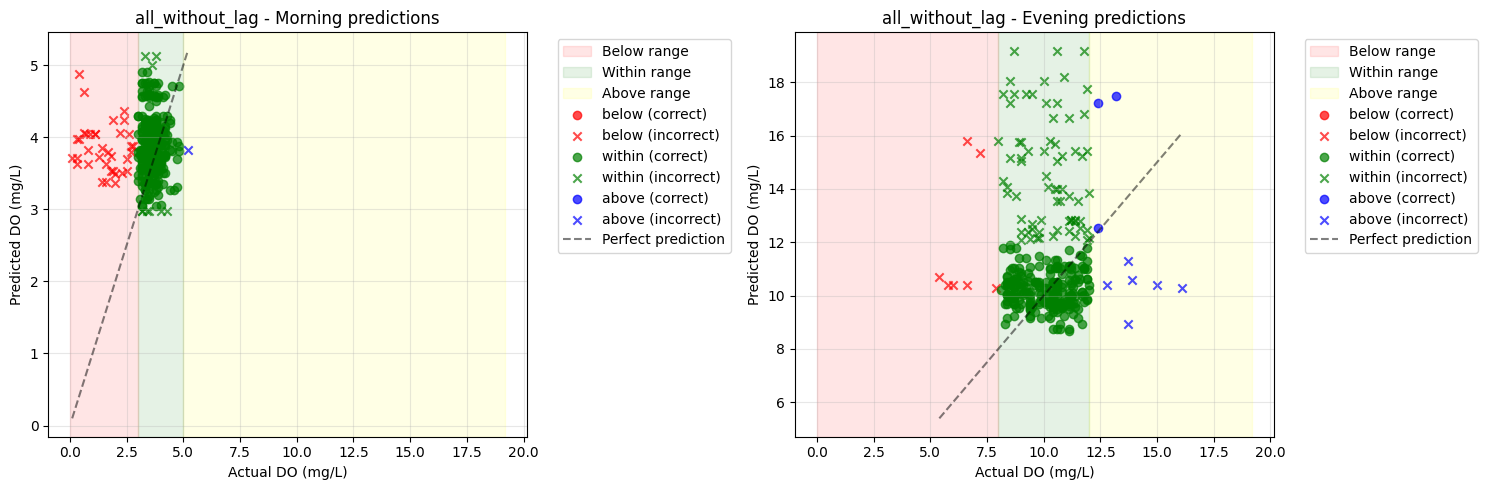

In [14]:
# Analyze predictions for each model
for name, y_pred in preds_dict.items():
    print(f"\nAnalyzing {name} model...")
    
    # Get actual values and time of day
    y_test = predict_df['do_mg_per_L']

    # Get range categories
    actual_range = get_in_required_range('do_mg_per_L', y_test, time_of_day)
    predicted_range = get_in_required_range('do_mg_per_L', y_pred, time_of_day)

    # Calculate metrics for each range category
    categories = ['below', 'within', 'above']
    for category in categories:
        actual_mask = actual_range == category
        pred_mask = predicted_range == category
        
        if actual_mask.any():
            category_rmse = root_mean_squared_error(y_test[actual_mask], y_pred[actual_mask])
            category_r2 = r2_score(y_test[actual_mask], y_pred[actual_mask])
            precision = precision_score(actual_range == category, predicted_range == category)
            recall = recall_score(actual_range == category, predicted_range == category)
            
            print(f"\n{category.capitalize()} range DO (n={actual_mask.sum():,})")
            print(f"RMSE: {category_rmse:.3f} | R²: {category_r2:.3f}")
            print(f"Precision: {precision:.3f} | Recall: {recall:.3f}")

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    colors = {'above': 'blue', 'within': 'green', 'below': 'red'}
    do_ranges = WQ_RANGES['do_mg_per_L']['required']

    for i, tod in enumerate(['morning', 'evening']):
        plt.subplot(1, 2, i+1)
        tod_mask = time_of_day == tod
        
        # Show prediction regions
        plt.axvspan(0, do_ranges[tod][0], alpha=0.1, color='red', label='Below range')
        plt.axvspan(do_ranges[tod][0], do_ranges[tod][1], alpha=0.1, color='green', label='Within range')
        plt.axvspan(do_ranges[tod][1], max(y_test.max(), y_pred.max()), 
                   alpha=0.1, color='yellow', label='Above range')
        
        # Plot points by category
        for category in categories:
            category_mask = tod_mask & (actual_range == category)
            correct_mask = category_mask & (actual_range == predicted_range)
            incorrect_mask = category_mask & (actual_range != predicted_range)
            
            plt.scatter(y_test[correct_mask], y_pred[correct_mask],
                       alpha=0.7, c=colors[category], marker='o',
                       label=f'{category} (correct)')
            plt.scatter(y_test[incorrect_mask], y_pred[incorrect_mask],
                       alpha=0.7, c=colors[category], marker='x',
                       label=f'{category} (incorrect)')

        # Add diagonal line
        plt.plot([y_test[tod_mask].min(), y_test[tod_mask].max()],
                 [y_test[tod_mask].min(), y_test[tod_mask].max()],
                 'k--', alpha=0.5, label='Perfect prediction')
        
        plt.xlabel('Actual DO (mg/L)')
        plt.ylabel('Predicted DO (mg/L)')
        plt.title(f'{name} - {tod.capitalize()} predictions')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()